In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [4]:
##LOAD TRAINING DATAFRAME

# categorical variable train dataframe

file_path_trainC = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"
train_cat = pd.read_excel(file_path_trainC)

# Functional Connectome Matrices

file_path_trainFCM = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

# Quantitative varaible train dataframe

file_path_trainQ = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_Quant = pd.read_excel(file_path_trainQ)

# ADHD and Sex solutions dataframe for model training

file_path_trainS = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_Solutions = pd.read_excel(file_path_trainS)

In [5]:
##LOAD TEST DATAFRAME

# categorical variable test dataframe

file_path_testC = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)

# Functional Connectome Matrices

file_path_testFCM = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

# Quantitative varaible test dataframe

file_path_testQ = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

### EDA ON TRAIN FCM

In [6]:
train_FCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 184.2+ MB


In [7]:
test_FCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 46.2+ MB


In [8]:
test_FCM.dtypes

participant_id           object
0throw_1thcolumn        float64
0throw_2thcolumn        float64
0throw_3thcolumn        float64
0throw_4thcolumn        float64
                         ...   
196throw_198thcolumn    float64
196throw_199thcolumn    float64
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
Length: 19901, dtype: object

In [9]:
train_FCM.dtypes

participant_id           object
0throw_1thcolumn        float64
0throw_2thcolumn        float64
0throw_3thcolumn        float64
0throw_4thcolumn        float64
                         ...   
196throw_198thcolumn    float64
196throw_199thcolumn    float64
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
Length: 19901, dtype: object

In [10]:
#Identify which region has the most activity (train)
train_FCM['max_activity_region'] = train_FCM.iloc[:, 1:1990].idxmax(axis=1)
train_FCM['max_activity_value'] = train_FCM.iloc[:, 1:1990].max(axis=1)
train_FCM_max = train_FCM[['participant_id','max_activity_region','max_activity_value']]
train_FCM_max.head()

,participant_id,max_activity_region,max_activity_value
0,70z8Q2xdTXM3,1throw_103thcolumn,0.314661
1,WHWymJu6zNZi,7throw_9thcolumn,0.215325
2,4PAQp1M6EyAo,1throw_103thcolumn,0.288996
3,obEacy4Of68I,2throw_102thcolumn,0.227515
4,s7WzzDcmDOhF,1throw_3thcolumn,0.236001


In [11]:
train_FCM_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   participant_id       1213 non-null   object 
 1   max_activity_region  1213 non-null   object 
 2   max_activity_value   1213 non-null   float64
dtypes: float64(1), object(2)
memory usage: 28.6+ KB


In [12]:
#Distibution of region with highest activity(train)
max_activity_region_counts = train_FCM_max['max_activity_region'].value_counts()
print(max_activity_region_counts)

max_activity_value_sorted = train_FCM_max.sort_values(by='max_activity_value', ascending=False)

print(max_activity_value_sorted)


max_activity_region
1throw_103thcolumn    436
2throw_102thcolumn    131
3throw_103thcolumn    115
1throw_3thcolumn      109
8throw_107thcolumn     74
                     ... 
5throw_196thcolumn      1
1throw_100thcolumn      1
8throw_10thcolumn       1
10throw_11thcolumn      1
8throw_22thcolumn       1
Name: count, Length: 84, dtype: int64
    participant_id max_activity_region  max_activity_value
486   LkE795nTZE14  3throw_103thcolumn            0.550239
788   Jh14rFpVd8Km  1throw_103thcolumn            0.538463
389   4VIE7TEmlPr9  1throw_103thcolumn            0.514260
645   CKkgPNyqu2OK  1throw_103thcolumn            0.505297
787   D3JcJiXCwQK2  1throw_103thcolumn            0.504691
..             ...                 ...                 ...
963   jEv0KvTTZ0Mj   6throw_10thcolumn            0.165244
932   BcN00QkRO7Vd  8throw_107thcolumn            0.163948
464   syeyZjEx8FUx  5throw_196thcolumn            0.161367
563   zHyPVux7ymz0    1throw_3thcolumn            0.156360
397   4

In [13]:
print(train_Solutions)

     participant_id  ADHD_Outcome  Sex_F
0      UmrK0vMLopoR             1      1
1      CPaeQkhcjg7d             1      0
2      Nb4EetVPm3gs             1      0
3      p4vPhVu91o4b             1      1
4      M09PXs7arQ5E             1      1
...             ...           ...    ...
1208   Atx7oub96GXS             0      0
1209   groSbUfkQngM             0      1
1210   zmxGvIrOD0bt             0      1
1211   rOmWFuJCud5G             0      0
1212   k8HhHnnu2wmt             0      0

[1213 rows x 3 columns]


In [14]:
#train solutions distributions
female_counts = train_Solutions['Sex_F'].value_counts()
print(female_counts)
adhd_counts = train_Solutions['ADHD_Outcome'].value_counts()
print(adhd_counts)

Sex_F
0    797
1    416
Name: count, dtype: int64
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


In [15]:
#one hot encoding on FCM 
train_encoded_FCM = pd.get_dummies(train_FCM_max['max_activity_region'], drop_first=True)
train_encoded_FCM = train_encoded_FCM.map(lambda x: 1 if x is True else (0 if x is False else x))
print(train_encoded_FCM)

# Combine encoded columns with the rest of the DataFrame
train_FCM_final = pd.concat([train_FCM_max, train_encoded_FCM], axis=1)

# ensure it looks correct
train_FCM_final.head()

      0throw_102thcolumn  0throw_103thcolumn  0throw_1thcolumn  \
0                      0                   0                 0   
1                      0                   0                 0   
2                      0                   0                 0   
3                      0                   0                 0   
4                      0                   0                 0   
...                  ...                 ...               ...   
1208                   0                   0                 0   
1209                   0                   0                 0   
1210                   0                   0                 0   
1211                   0                   0                 0   
1212                   0                   0                 0   

      0throw_29thcolumn  0throw_2thcolumn  0throw_3thcolumn  0throw_6thcolumn  \
0                     0                 0                 0                 0   
1                     0                 0    

,participant_id,max_activity_region,max_activity_value,0throw_102thcolumn,0throw_103thcolumn,0throw_1thcolumn,0throw_29thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_6thcolumn,...,8throw_60thcolumn,8throw_65thcolumn,8throw_83thcolumn,8throw_90thcolumn,8throw_92thcolumn,8throw_97thcolumn,9throw_108thcolumn,9throw_109thcolumn,9throw_10thcolumn,9throw_11thcolumn
0,70z8Q2xdTXM3,1throw_103thcolumn,0.314661,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WHWymJu6zNZi,7throw_9thcolumn,0.215325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4PAQp1M6EyAo,1throw_103thcolumn,0.288996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,obEacy4Of68I,2throw_102thcolumn,0.227515,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,s7WzzDcmDOhF,1throw_3thcolumn,0.236001,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#combine solutions with FCM 
train_FCM_final = train_FCM_final[['participant_id','1throw_103thcolumn']]
print(train_FCM_final)

train_sol_FCM_final = pd.merge(train_FCM_final, train_Solutions, on = 'participant_id')
print(train_sol_FCM_final)

     participant_id  1throw_103thcolumn
0      70z8Q2xdTXM3                   1
1      WHWymJu6zNZi                   0
2      4PAQp1M6EyAo                   1
3      obEacy4Of68I                   0
4      s7WzzDcmDOhF                   0
...             ...                 ...
1208   kTurROKp5YHQ                   1
1209   FCRyMz9O6yCq                   0
1210   vm2P1hmAY1hl                   0
1211   OFxvN8lnw21w                   0
1212   9gpepMI9sj5q                   0

[1213 rows x 2 columns]
     participant_id  1throw_103thcolumn  ADHD_Outcome  Sex_F
0      70z8Q2xdTXM3                   1             1      0
1      WHWymJu6zNZi                   0             1      1
2      4PAQp1M6EyAo                   1             1      1
3      obEacy4Of68I                   0             1      1
4      s7WzzDcmDOhF                   0             1      1
...             ...                 ...           ...    ...
1208   kTurROKp5YHQ                   1             0      1
1209   

ADHD_Outcome          0    1
1throw_103thcolumn          
0                   248  529
1                   134  302


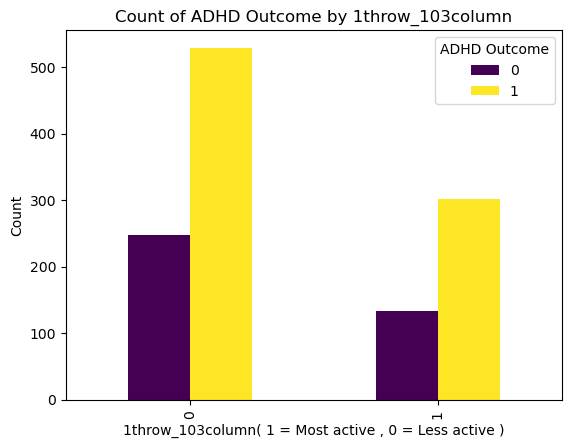

In [18]:
#check correlation of most active region with ADHD outcome 

# create contingency table 
ct_ADHD_active_region = pd.crosstab(train_sol_FCM_final['1throw_103thcolumn'], train_sol_FCM_final['ADHD_Outcome'])
print(ct_ADHD_active_region)

#create stacked bar chart
ct_ADHD_active_region .plot(kind='bar', colormap='viridis')
plt.title("Count of ADHD Outcome by 1throw_103column")
plt.xlabel("1throw_103column( 1 = Most active , 0 = Less active )")
plt.ylabel("Count")
plt.legend(title="ADHD Outcome")
plt.show()

Sex_F                 0    1
1throw_103thcolumn          
0                   500  277
1                   297  139


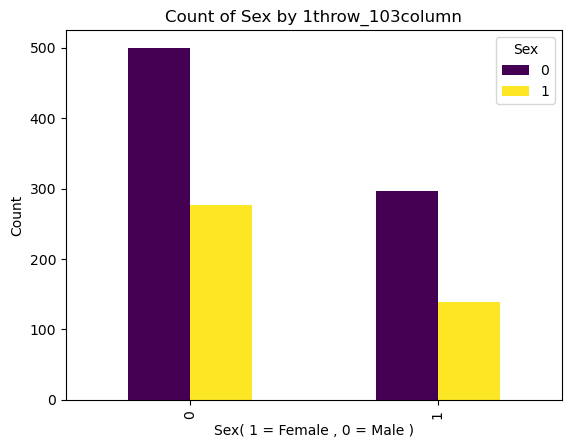

In [19]:
#check correlation of most active region with Sex 

# create contingency table 
ct_sex_active_region = pd.crosstab(train_sol_FCM_final['1throw_103thcolumn'], train_sol_FCM_final['Sex_F'])
print(ct_sex_active_region)

#create stacked bar chart
ct_sex_active_region .plot(kind='bar', colormap='viridis')
plt.title("Count of Sex by 1throw_103column")
plt.xlabel("Sex( 1 = Female , 0 = Male )")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.show()

ADHD_Outcome          0   1
max_activity_region        
0throw_100thcolumn   10  10
0throw_102thcolumn    0   1
0throw_103thcolumn    0   2
0throw_1thcolumn      3   4
0throw_29thcolumn     0   2
...                  ..  ..
8throw_97thcolumn     0   3
9throw_108thcolumn   19  28
9throw_109thcolumn    6  13
9throw_10thcolumn     1   4
9throw_11thcolumn     1   0

[84 rows x 2 columns]


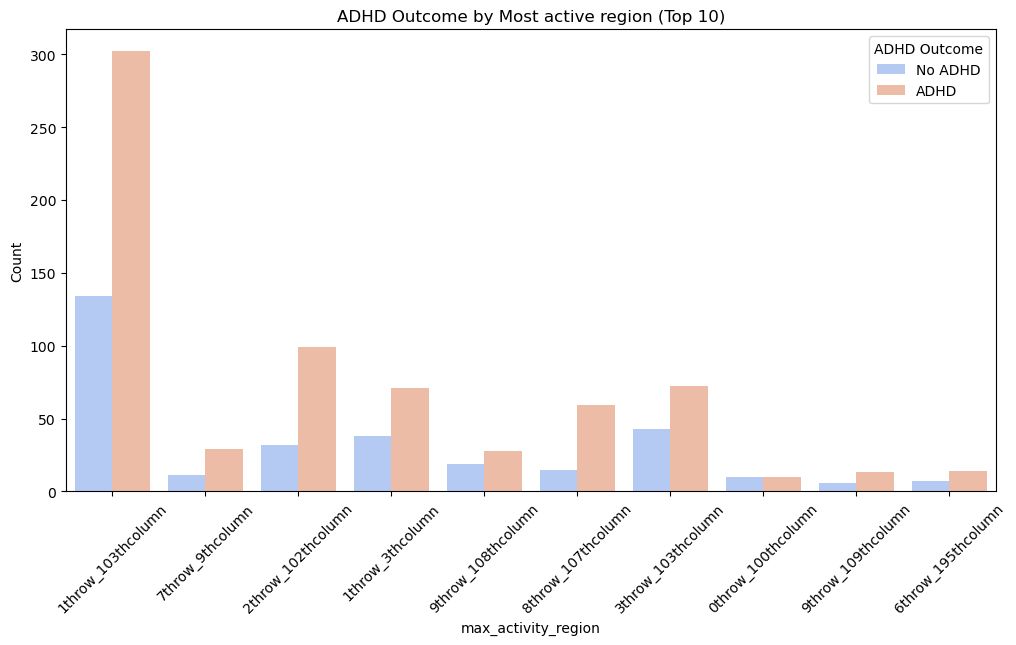

In [20]:
#identify most active region in ADHD patient
#merge FCM max and solutions 
train_sol_FCM_max = pd.merge(train_FCM_max, train_Solutions, on = 'participant_id')

# create contingency table FCM max and adhd outcome
ct_ADHD_max_activity_regions = pd.crosstab(train_sol_FCM_max['max_activity_region'], train_sol_FCM_max['ADHD_Outcome'])
print(ct_ADHD_max_activity_regions)

# bar chart (top 10)

# Count occurrences
category_counts = train_sol_FCM_max['max_activity_region'].value_counts()

# Select top 10 categories
top_categories = category_counts.index[:10]
dfadhd_filtered = train_sol_FCM_max[train_sol_FCM_max['max_activity_region'].isin(top_categories)]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='max_activity_region', hue='ADHD_Outcome', data=dfadhd_filtered, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("ADHD Outcome by Most active region (Top 10)")
plt.xlabel("max_activity_region")
plt.ylabel("Count")
plt.legend(title="ADHD Outcome", labels=["No ADHD", "ADHD"])
plt.show()

Sex_F                 0   1
max_activity_region        
0throw_100thcolumn   13   7
0throw_102thcolumn    0   1
0throw_103thcolumn    2   0
0throw_1thcolumn      6   1
0throw_29thcolumn     2   0
...                  ..  ..
8throw_97thcolumn     2   1
9throw_108thcolumn   36  11
9throw_109thcolumn   15   4
9throw_10thcolumn     2   3
9throw_11thcolumn     0   1

[84 rows x 2 columns]


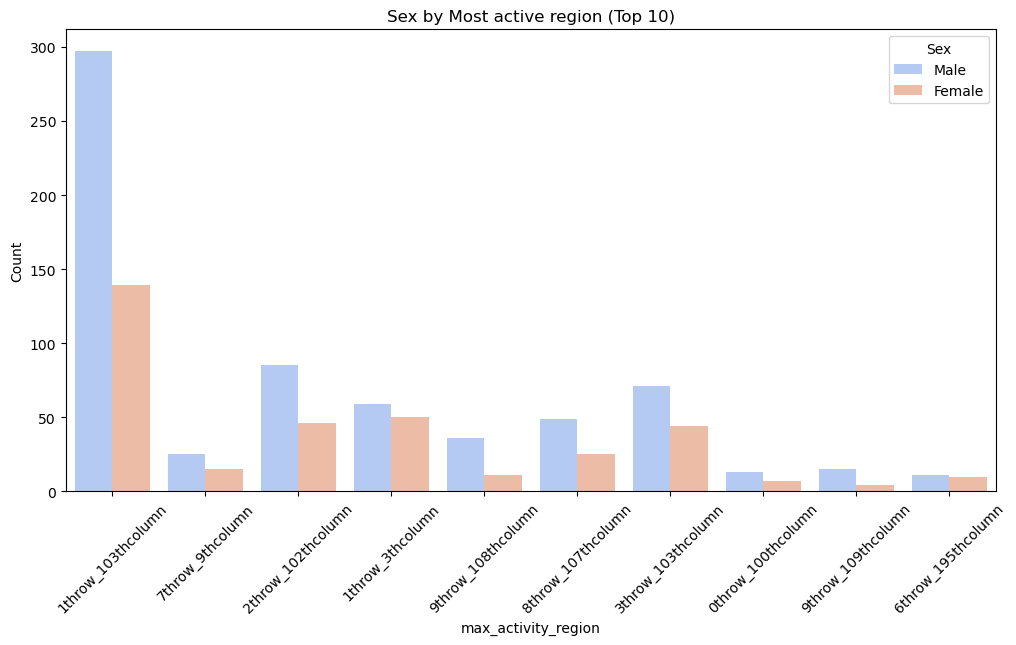

In [21]:
#identify most active region in different sex 
#merge FCM max and solutions 
train_sol_FCM_max = pd.merge(train_FCM_max, train_Solutions, on = 'participant_id')

# create contingency table FCM max and adhd outcome
ct_sex_max_activity_regions = pd.crosstab(train_sol_FCM_max['max_activity_region'], train_sol_FCM_max['Sex_F'])
print(ct_sex_max_activity_regions)

# bar chart (top 10)

# Count occurrences
category_counts = train_sol_FCM_max['max_activity_region'].value_counts()

# Select top 10 categories
top_categories = category_counts.index[:10]
dfsex_filtered = train_sol_FCM_max[train_sol_FCM_max['max_activity_region'].isin(top_categories)]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='max_activity_region', hue='Sex_F', data=dfsex_filtered, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Sex by Most active region (Top 10)")
plt.xlabel("max_activity_region")
plt.ylabel("Count")
plt.legend(title="Sex", labels=["Male", "Female"])
plt.show()

Sex_F           0    1
ADHD_Outcome          
0             216  166
1             581  250


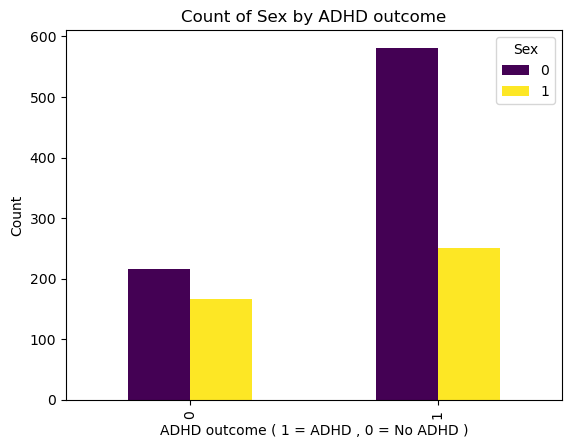

In [22]:
#check correlation of ADHD with Sex 

# create contingency table 
ct_sex_adhd = pd.crosstab(train_Solutions['ADHD_Outcome'], train_Solutions['Sex_F'])
print(ct_sex_adhd )

#create stacked bar chart
ct_sex_adhd.plot(kind='bar', colormap='viridis')
plt.title("Count of Sex by ADHD outcome")
plt.xlabel("ADHD outcome ( 1 = ADHD , 0 = No ADHD )")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.show()

In [23]:
#count males and females entry 
sex_counts = train_Solutions['Sex_F'].value_counts()
print(sex_counts)

Sex_F
0    797
1    416
Name: count, dtype: int64


In [24]:
#count males and females entry 
sex_counts = train_Solutions['ADHD_Outcome'].value_counts()
print(sex_counts)

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


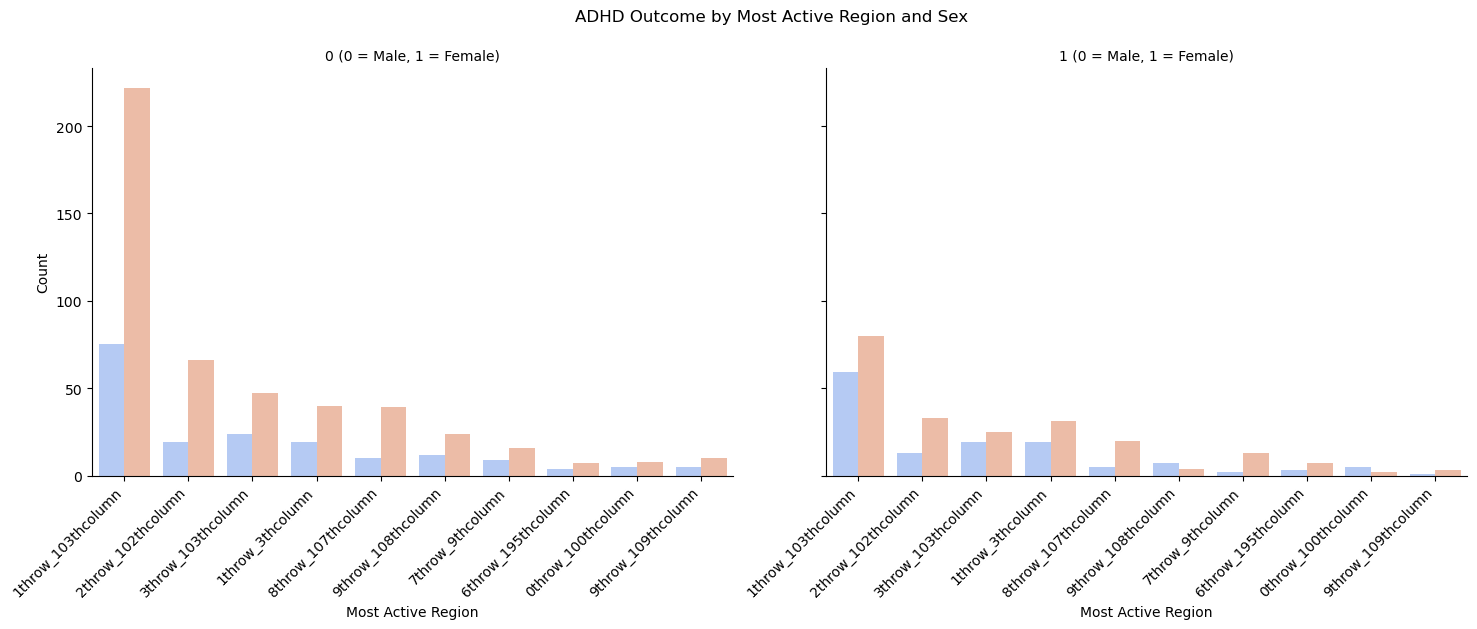

In [51]:
#add sex variable

# Select top 10 most frequent activity regions
top_categories = train_sol_FCM_max['max_activity_region'].value_counts().index[:10]
df_filtered = train_sol_FCM_max[train_sol_FCM_max['max_activity_region'].isin(top_categories)]

# Create facet grid (Separate plots for each sex)
g = sns.FacetGrid(df_filtered, col="Sex_F", height=5, aspect=1.5)
g.map_dataframe(sns.countplot, x="max_activity_region", hue="ADHD_Outcome", palette="coolwarm", order=top_categories)

# Formatting
g.set_axis_labels("Most Active Region", "Count")
g.set_titles(col_template="{col_name} (0 = Male, 1 = Female)")
g.fig.suptitle("ADHD Outcome by Most Active Region and Sex", y=1.05)
# Set fixed ticks before modifying labels
for ax in g.axes.flat:  
    ax.set_xticks(ax.get_xticks())  # Ensure tick positions are fixed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate safely

plt.show()

### EDA ON TRAIN CAT

In [125]:
 train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   participant_id                    1213 non-null   object  
 1   Basic_Demos_Enroll_Year           1213 non-null   category
 2   Basic_Demos_Study_Site            1213 non-null   category
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64 
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   category
 5   MRI_Track_Scan_Location           1213 non-null   category
 6   Barratt_Barratt_P1_Edu            1213 non-null   category
 7   Barratt_Barratt_P1_Occ            1213 non-null   category
 8   Barratt_Barratt_P2_Edu            1213 non-null   category
 9   Barratt_Barratt_P2_Occ            1213 non-null   category
dtypes: category(8), float64(1), object(1)
memory usage: 31.0+ KB


In [127]:
# Merge all datasets on participant_id
train_df = pd.merge(train_cat, train_Solutions, on='participant_id')
# ensure it looks accurate
train_df.head()


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45,1,1
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0,1,0
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0,1,0
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0,1,1
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0,1,1


In [129]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   participant_id                    1213 non-null   object  
 1   Basic_Demos_Enroll_Year           1213 non-null   category
 2   Basic_Demos_Study_Site            1213 non-null   category
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64 
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   category
 5   MRI_Track_Scan_Location           1213 non-null   category
 6   Barratt_Barratt_P1_Edu            1213 non-null   category
 7   Barratt_Barratt_P1_Occ            1213 non-null   category
 8   Barratt_Barratt_P2_Edu            1213 non-null   category
 9   Barratt_Barratt_P2_Occ            1213 non-null   category
 10  ADHD_Outcome                      1213 non-null   int64   
 11  Sex_F                             1213 non-null   int64 

In [131]:
 train_Solutions['ADHD_Outcome'].value_counts()

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

In [133]:
## ONE HOT ENCODING
#converts all integer colummns to categorical columns
for col in train_cat.select_dtypes(include='int').columns:
 train_cat[col] = train_cat[col].astype('category')

# Creating a list of all of the columns except the first
columns_to_encode = train_cat.columns[1:].tolist()
    
# Print the columns to encode
print("Columns to encode:", columns_to_encode)

# encoding categorical data
train_encoded = pd.get_dummies(train_cat[columns_to_encode], drop_first=True)
train_encoded = train_encoded.map(lambda x: 1 if x is True else (0 if x is False else x)) 

# Combine encoded columns with the rest of the DataFrame
cat_train_final = pd.concat([train_cat.drop(columns=columns_to_encode), train_encoded] , axis = 1)
                              
# ensure it looks correct
cat_train_final.head()

Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


,participant_id,PreInt_Demos_Fam_Child_Ethnicity,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,...,Barratt_Barratt_P2_Edu_21,Barratt_Barratt_P2_Occ_5,Barratt_Barratt_P2_Occ_10,Barratt_Barratt_P2_Occ_15,Barratt_Barratt_P2_Occ_20,Barratt_Barratt_P2_Occ_25,Barratt_Barratt_P2_Occ_30,Barratt_Barratt_P2_Occ_35,Barratt_Barratt_P2_Occ_40,Barratt_Barratt_P2_Occ_45
0,UmrK0vMLopoR,0.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,CPaeQkhcjg7d,1.0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Nb4EetVPm3gs,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,p4vPhVu91o4b,0.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,M09PXs7arQ5E,0.0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
train_cat_FCM = pd.merge(cat_train_final, train_FCM, on = 'participant_id')
print(train_df.isna().sum())

participant_id                       0
Basic_Demos_Enroll_Year              0
Basic_Demos_Study_Site               0
PreInt_Demos_Fam_Child_Ethnicity    11
PreInt_Demos_Fam_Child_Race          0
MRI_Track_Scan_Location              0
Barratt_Barratt_P1_Edu               0
Barratt_Barratt_P1_Occ               0
Barratt_Barratt_P2_Edu               0
Barratt_Barratt_P2_Occ               0
ADHD_Outcome                         0
Sex_F                                0
dtype: int64


In [137]:
train_df.ffill(inplace=True)
print(train_df.isna().sum().sum())

0


In [139]:
merged_df = train_Quant.merge(train_cat, on='participant_id', how='left')

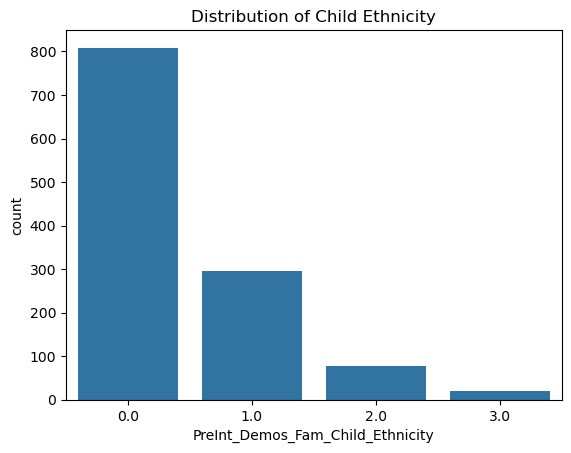

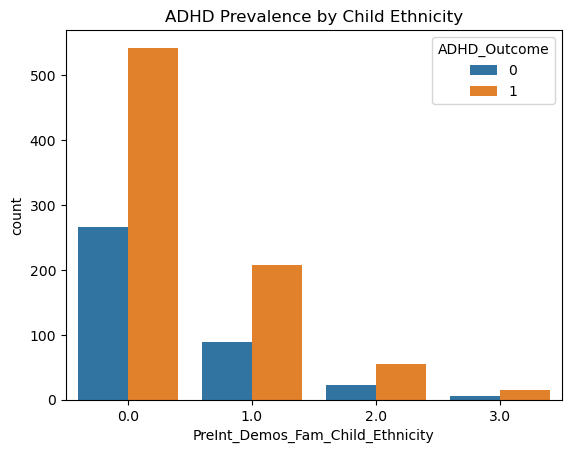

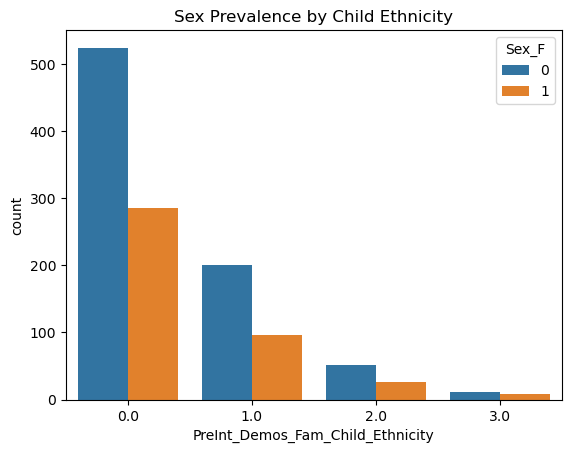

In [145]:
# Merge the two DataFrames to ensure 'ADHD_Outcome' is inside train_cat
train_cat_sol = train_cat.merge(train_Solutions, on='participant_id', how='left')

sns.countplot(x='PreInt_Demos_Fam_Child_Ethnicity', data=train_cat_sol)
plt.title('Distribution of Child Ethnicity')
plt.show()
sns.countplot(x='PreInt_Demos_Fam_Child_Ethnicity', data=train_cat_sol,hue='ADHD_Outcome')
plt.title('ADHD Prevalence by Child Ethnicity')
plt.show()
sns.countplot(x='PreInt_Demos_Fam_Child_Ethnicity', data=train_cat_sol,hue='Sex_F')
plt.title('Sex Prevalence by Child Ethnicity')
plt.show()

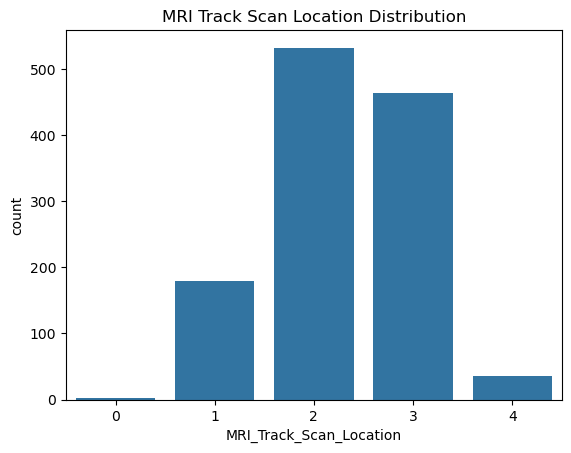

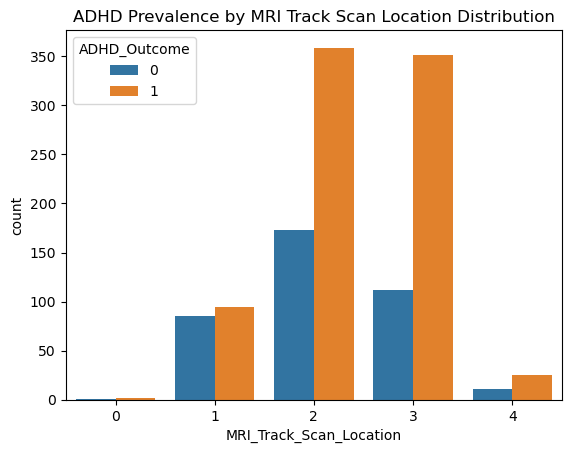

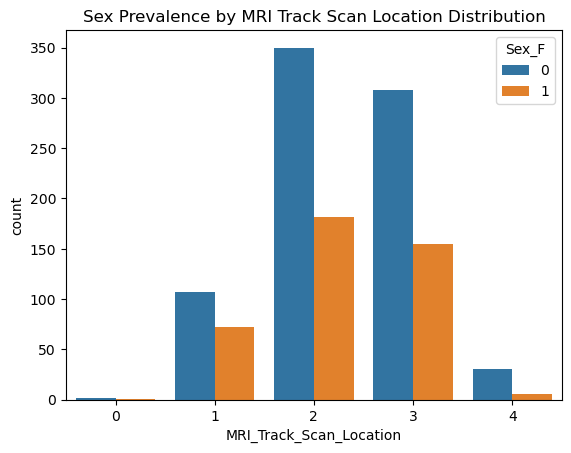

In [151]:
sns.countplot(x='MRI_Track_Scan_Location', data=train_cat_sol)
plt.title('MRI Track Scan Location Distribution')
plt.show()
sns.countplot(x='MRI_Track_Scan_Location', data=train_cat_sol, hue='ADHD_Outcome')
plt.title('ADHD Prevalence by MRI Track Scan Location Distribution')
plt.show()
sns.countplot(x='MRI_Track_Scan_Location', data=train_cat_sol, hue='Sex_F')
plt.title('Sex Prevalence by MRI Track Scan Location Distribution')
plt.show()

In [153]:
 train_cat['Barratt_Barratt_P1_Occ'].value_counts()

Barratt_Barratt_P1_Occ
0     317
35    219
45    187
30    154
40    154
25     79
15     35
5      31
20     31
10      6
Name: count, dtype: int64

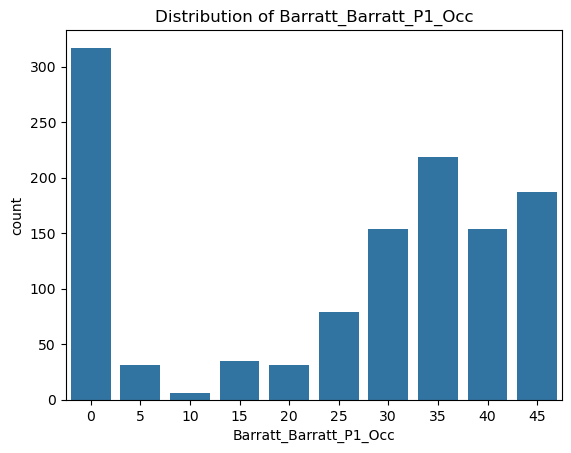

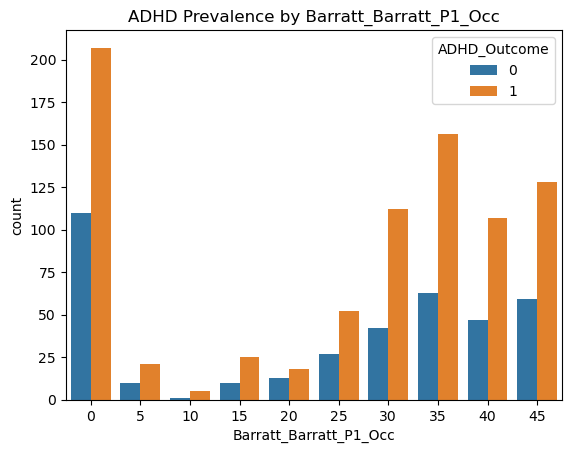

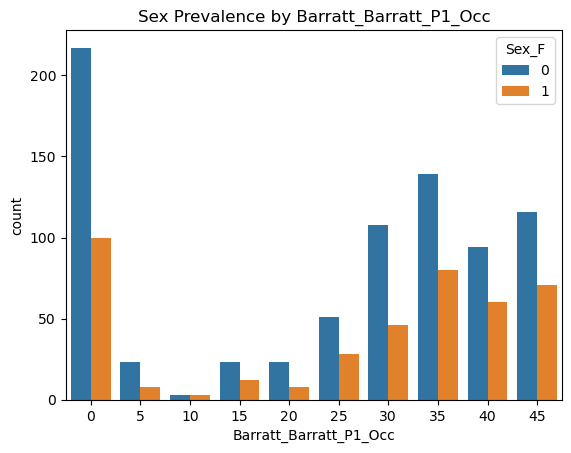

In [155]:
sns.countplot(x='Barratt_Barratt_P1_Occ', data=train_cat_sol )
plt.title(f"Distribution of Barratt_Barratt_P1_Occ")
plt.show()
sns.countplot(x='Barratt_Barratt_P1_Occ', data=train_cat_sol , hue = 'ADHD_Outcome')
plt.title(f"ADHD Prevalence by Barratt_Barratt_P1_Occ")
plt.show()
sns.countplot(x='Barratt_Barratt_P1_Occ', data=train_cat_sol ,hue = 'Sex_F')
plt.title(f"Sex Prevalence by Barratt_Barratt_P1_Occ")
plt.show()

In [157]:
train_cat['Barratt_Barratt_P2_Occ'].value_counts()

Barratt_Barratt_P2_Occ
0     287
45    239
35    195
30    149
40    116
15     86
20     41
5      38
10     37
25     25
Name: count, dtype: int64

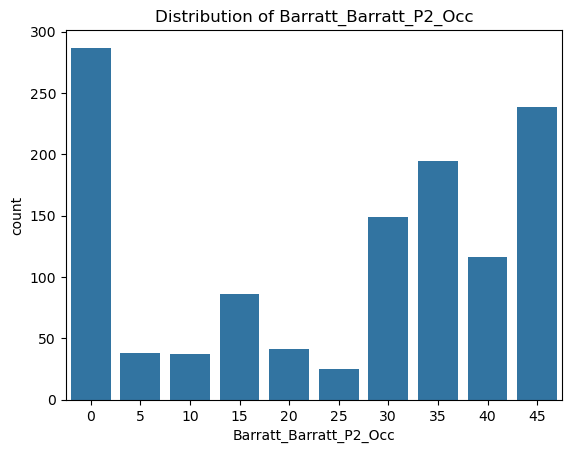

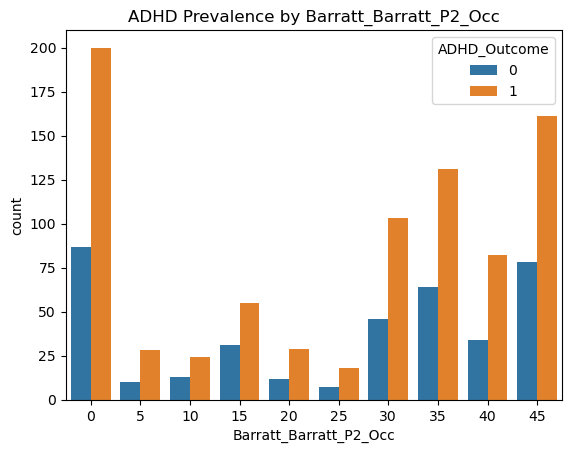

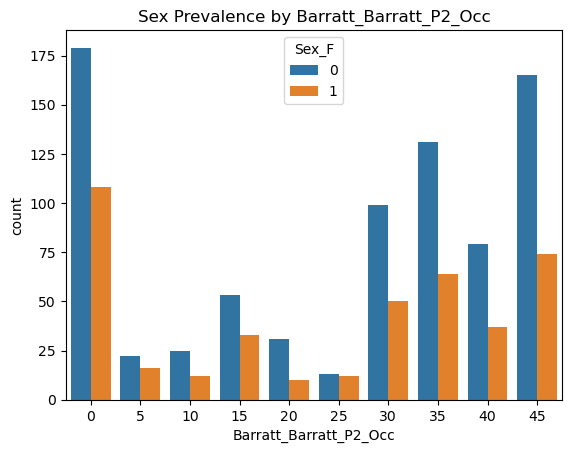

In [161]:
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat_sol )
plt.title(f"Distribution of Barratt_Barratt_P2_Occ")
plt.show()
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat_sol , hue = 'ADHD_Outcome') 
plt.title(f"ADHD Prevalence by Barratt_Barratt_P2_Occ")
plt.show()
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat_sol , hue = 'Sex_F' )
plt.title(f"Sex Prevalence by Barratt_Barratt_P2_Occ")
plt.show()

In [ ]:
train_cat['Barratt_Barratt_P1_Edu'].value_counts()

In [163]:
train_cat['Barratt_Barratt_P2_Edu'].value_counts()

Barratt_Barratt_P2_Edu
21    323
18    301
0     198
15    166
12    162
9      44
6      14
3       5
Name: count, dtype: int64

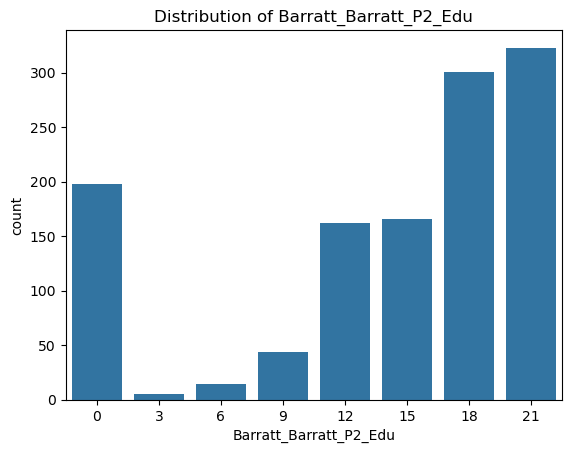

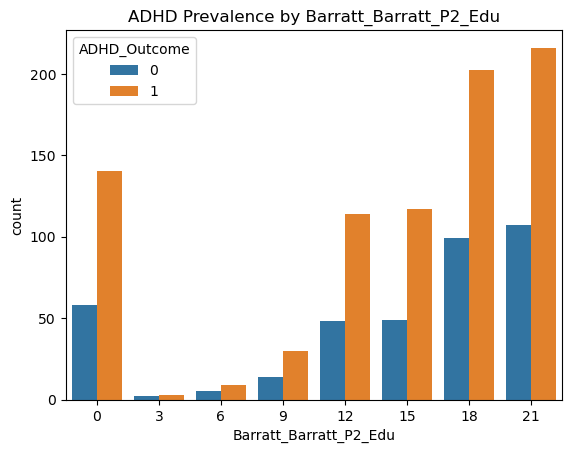

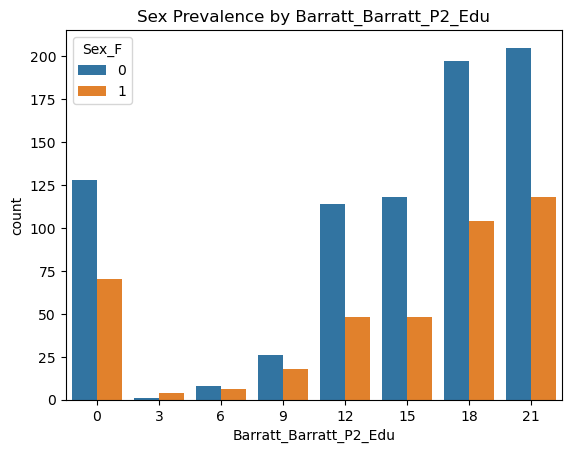

In [165]:
sns.countplot(x='Barratt_Barratt_P2_Edu', data=train_cat_sol )
plt.title(f"Distribution of Barratt_Barratt_P2_Edu")
plt.show()
sns.countplot(x='Barratt_Barratt_P2_Edu', data=train_cat_sol , hue = 'ADHD_Outcome') 
plt.title(f"ADHD Prevalence by Barratt_Barratt_P2_Edu")
plt.show()
sns.countplot(x='Barratt_Barratt_P2_Edu', data=train_cat_sol , hue = 'Sex_F' )
plt.title(f"Sex Prevalence by Barratt_Barratt_P2_Edu")
plt.show()

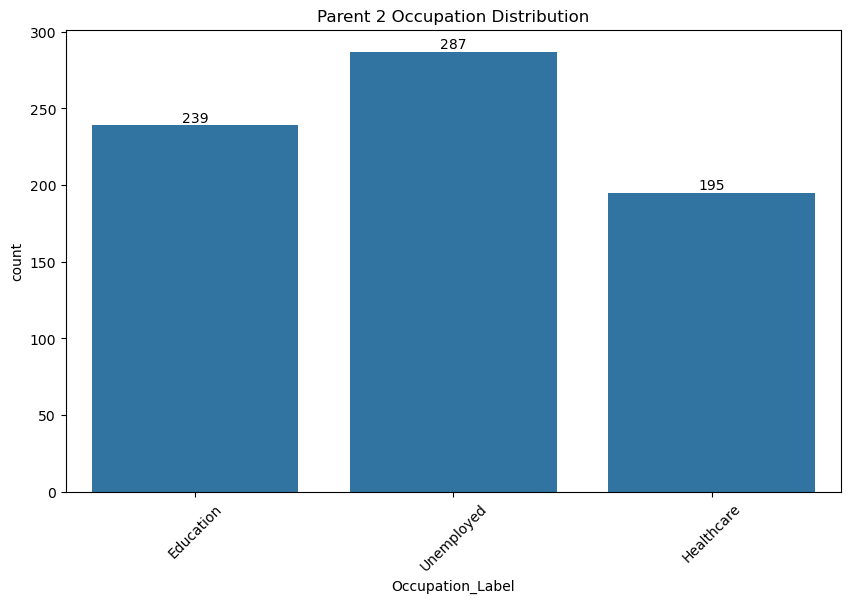

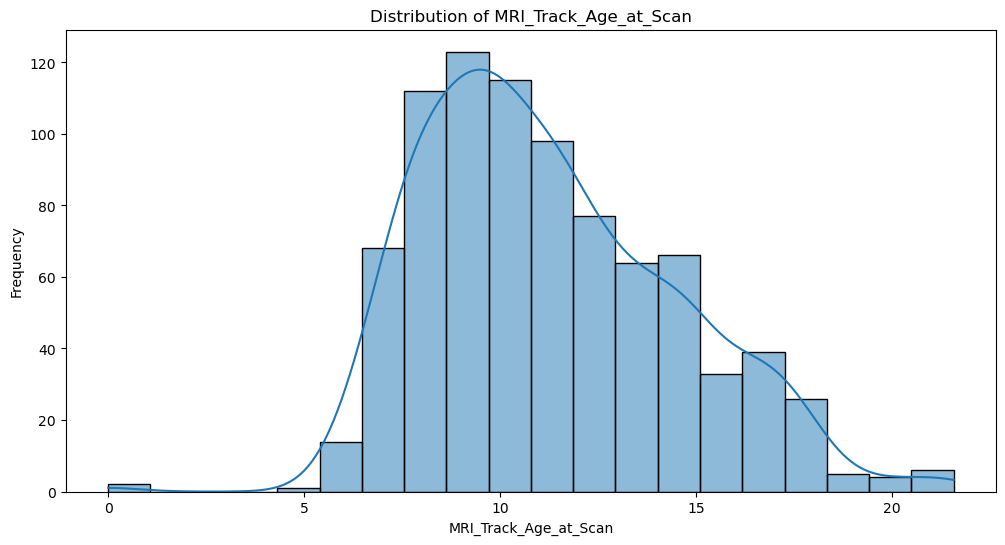

In [ ]:
# Data Cleaning Pipeline
def clean_data(df):
    # Handle missing values
    df = df.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'object' else x.fillna(x.median()))
    
    # Remove duplicate entries
    df = df.drop_duplicates()
    
    # Optimize memory usage for large datasets
    for col in df.select_dtypes(include='integer'):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include='float'):
        df[col] = pd.to_numeric(df[col], downcast='float')
        
    return df

# Apply cleaning to categorical data
train_cat_clean = clean_data(train_cat)

# EDA Functions
def plot_categorical_distribution(df, column, title, figsize=(10,6)):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=df)
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    plt.show()

def plot_numeric_distribution(df, column, bins=20):
    plt.figure(figsize=(12,6))
    sns.histplot(df[column], kde=True, bins=bins)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Categorical Variable Analysis
# Replace with actual category mappings from data dictionary
OCCUPATION_MAP = {
    0: 'Unemployed',
    35: 'Healthcare',
    45: 'Education',
    # Add all mappings from Kaggle data dictionary
}

# Analyze Parent Occupation
train_cat['Occupation_Label'] = train_cat['Barratt_Barratt_P2_Occ'].map(OCCUPATION_MAP)
plot_categorical_distribution(train_cat, 'Occupation_Label', 
                             'Parent 2 Occupation Distribution')

# Quantitative Variable Analysis
plot_numeric_distribution(train_Quant, 'MRI_Track_Age_at_Scan')

# ADHD Outcome Analysis
plt.figure(figsize=(10,6))
adhd_counts = train_Solutions['ADHD_Outcome'].value_counts()
adhd_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('ADHD Diagnosis Distribution')
plt.xlabel('ADHD Diagnosis (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Gender Distribution Analysis
plt.figure(figsize=(10,6))
gender_counts = train_Solutions['Sex_F'].value_counts()
gender_counts.plot(kind='bar', color=['#2ca02c', '#d62728'])
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# SDQ Emotional Problems Analysis
plot_numeric_distribution(train_Quant, 'SDQ_SDQ_Emotional_Problems')

# Correlation with ADHD Outcome
merged_data = train_Quant.merge(train_Solutions, on='participant_id')

plt.figure(figsize=(10,6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Emotional_Problems', data=merged_data)
plt.title('Emotional Problems Score by ADHD Status')
plt.xlabel('ADHD Diagnosis')
plt.ylabel('Emotional Problems Score')
plt.show()

# Statistical Testing
def calculate_effect_sizes(df, target_col='ADHD_Outcome'):
    results = []
    adhd_positive = df[df[target_col] == 1]
    adhd_negative = df[df[target_col] == 0]
    
    for col in df.select_dtypes(include=np.number).columns:
        if col != target_col:
            # Mann-Whitney U test
            stat, p = stats.mannwhitneyu(adhd_positive[col], adhd_negative[col])
            # Cohen's d effect size
            pooled_std = np.sqrt((adhd_positive[col].std()**2 + adhd_negative[col].std()**2)/2)
            d = (adhd_positive[col].mean() - adhd_negative[col].mean()) / pooled_std
            
            results.append({
                'Variable': col,
                'MannWhitney_U': stat,
                'p_value': p,
                'Effect_Size': d,
                'ADHD_Mean': adhd_positive[col].mean(),
                'Non_ADHD_Mean': adhd_negative[col].mean()
            })
    
    return pd.DataFrame(results)

# Calculate for all numeric variables (might take time for large datasets)
effect_size_df = calculate_effect_sizes(merged_data)
print("Top Variables Correlated with ADHD:")
print(effect_size_df.sort_values('Effect_Size', key=abs, ascending=False).head(10))

# Memory optimization for large quantitative datasets
if train_Quant.memory_usage().sum() > 1e9:  # If >1GB
    print("\nLarge Dataset Optimization:")
    original_memory = train_Quant.memory_usage().sum()/1e6
    # Downcast numeric types
    train_Quant = train_Quant.apply(lambda x: pd.to_numeric(x, downcast='integer') 
                                  if np.issubdtype(x.dtype, np.integer) else x)
    train_Quant = train_Quant.apply(lambda x: pd.to_numeric(x, downcast='float'))
    optimized_memory = train_Quant.memory_usage().sum()/1e6
    print(f"Memory reduced from {original_memory:.1f}MB to {optimized_memory:.1f}MB")

In [ ]:
# Top Variables Analysis
def calculate_effect_size(adhd_group, control_group):
    """Calculate Cohen's d effect size"""
    diff = adhd_group.mean() - control_group.mean()
    pooled_std = np.sqrt((adhd_group.std()**2 + control_group.std()**2)/2)
    return diff/pooled_std

# Prepare groups
adhd_group = merged_df[merged_df['ADHD_Outcome'] == 1]
control_group = merged_df[merged_df['ADHD_Outcome'] == 0]

# Analyze all quantitative variables
results = []
for col in merged_df.select_dtypes(include=np.number).columns:
    if col not in ['participant_id', 'ADHD_Outcome']:
        # Statistical test
        t_stat, p_val = stats.mannwhitneyu(adhd_group[col], control_group[col])
        
        # Effect size
        d = calculate_effect_size(adhd_group[col], control_group[col])
        
        results.append({
            'Variable': col,
            'MannWhitney_U': t_stat,
            'p_value': p_val,
            'Effect_Size': abs(d),  # Absolute value for ranking
            'ADHD_Mean': adhd_group[col].mean(),
            'Control_Mean': control_group[col].mean()
        })

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Effect_Size', ascending=False)

# Display top 10 variables
print("\nTop 10 Variables Correlated with ADHD:")
top_vars = results_df.head(10)
display(top_vars[['Variable', 'Effect_Size', 'p_value', 'ADHD_Mean', 'Control_Mean']])

# Visualization of Top Variables
for var in top_vars['Variable'].head(3):
    plt.figure(figsize=(12, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=merged_df, x=var, hue='ADHD_Outcome', 
                element='step', stat='density', common_norm=False)
    plt.title(f'{var} Distribution')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x='ADHD_Outcome', y=var, data=merged_df)
    plt.title(f'{var} vs ADHD Status')
    
    plt.tight_layout()
    plt.show()

# Age Distribution Analysis
plt.figure(figsize=(10, 6))
merged_df['MRI_Track_Age_at_Scan'].hist(bins=20, color='teal')
plt.title('Age Distribution at Time of MRI Scan')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

# Correlation Matrix for Top Variables
top_vars_list = top_vars['Variable'].tolist()[:5] + ['ADHD_Outcome']
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[top_vars_list].corr(), 
           annot=True, cmap='coolwarm', center=0)
plt.title('Top Variables Correlation Matrix')
plt.show()